<a href="https://colab.research.google.com/github/suhani6/CustomerSegmentation/blob/main/CustomerSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation Project
## Step 1 - Import Necessary Libraries
*   **pandas** and **numpy** are used for data manipulation and numerical calculations.
*   **datetime** helps with date conversions.
*   **StandardScaler** from sklearn is used to scale data for clustering.
*   **KMeans** is used for clustering.
*   **seaborn** and **matplotlib** help with data visualization.



In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import os
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/My Drive/'

In [ ]:
os.getcwd()

'/content'

# Step 2 - Load the Dataset


*   Load the dataset using pd.read_excel for Excel files.
*   Make sure the dataset has key fields like **CustomerID**, **InvoiceDate**, **Country**, etc.




In [ ]:
df = pd.read_csv(os.path.join(data_dir, "Online Retail.csv"), dtype={'InvoiceNo': str, 'CustomerID': str})
df.to_csv('Online_Retail_clean.csv', index=False)

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


# Step 3: Data Cleaning


*   **Handling missing values:** Rows with missing CustomerID are removed.
*   **Data conversion:** The InvoiceDate is converted to a datetime format.
*   **Negative values:** Remove negative quantity transactions.
*  **Creating TotalPrice:** Multiply Quantity and UnitPrice to get total transaction values.




In [ ]:
df = df.dropna(subset=['CustomerID'])

In [ ]:
df = df[df['Quantity'] > 0]

# Step 4: RFM Analysis (Recency, Frequency, Monetary)



*   List item
*   List item



In [ ]:

# Define the current date
current_date = dt.datetime(2011, 12, 10)  # Use a fixed date from your dataset or the present date

# Calculate Recency
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
recency_df = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (current_date - x.max()).days}).reset_index()
recency_df.columns = ['CustomerID', 'Recency']

In [ ]:
recency_df.head()

,CustomerID,Recency
0,12346,325
1,12347,2
2,12348,75
3,12349,18
4,12350,310


In [ ]:
frequency_df = df.groupby('CustomerID').agg({'InvoiceNo': 'nunique'}).reset_index()
frequency_df.columns = ['CustomerID', 'Frequency']

In [ ]:
frequency_df.head()

,CustomerID,Frequency
0,12346,1
1,12347,7
2,12348,4
3,12349,1
4,12350,1


In [ ]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
monetary_df = df.groupby('CustomerID').agg({'TotalPrice': 'sum'}).reset_index()
monetary_df.columns = ['CustomerID', 'Monetary']

In [ ]:
monetary_df.head()

,CustomerID,Monetary
0,12346,77183.60
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


In [ ]:
rfm = recency_df.merge(frequency_df, on='CustomerID').merge(monetary_df, on='CustomerID')

In [ ]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,18,1,1757.55
4,12350,310,1,334.40


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'], index=rfm.CustomerID)

In [ ]:
rfm_scaled_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,0.871314,0.000000,0.275453
12347,0.005362,0.028708,0.015382
12348,0.201072,0.014354,0.006414
12349,0.048257,0.000000,0.006272
12350,0.831099,0.000000,0.001193


In [ ]:
from sklearn.cluster import KMeans

# Apply K-means with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled_df)

# View the clusters
rfm.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346,325,1,77183.60,4
1,12347,2,7,4310.00,0
2,12348,75,4,1797.24,3
3,12349,18,1,1757.55,0
4,12350,310,1,334.40,4


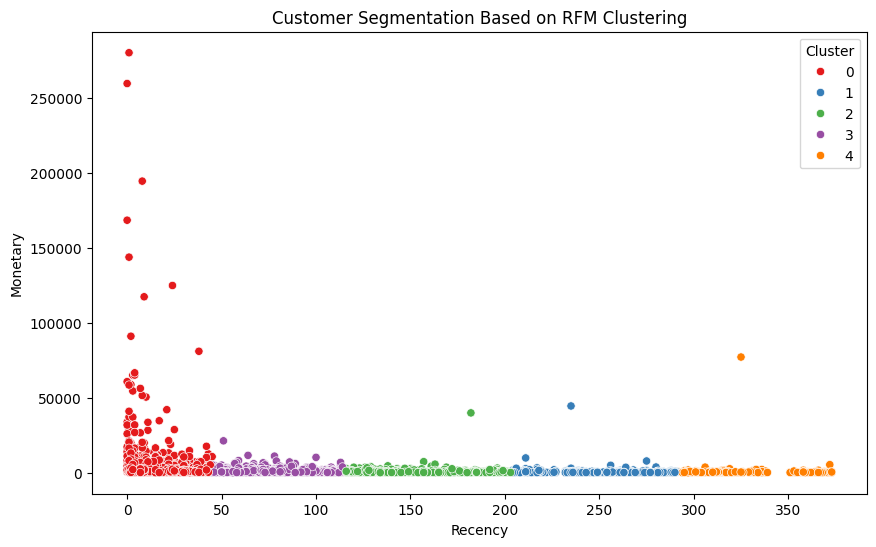

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rfm, palette='Set1')
plt.title('Customer Segmentation Based on RFM Clustering')
plt.show()

In [ ]:
country_agg = df.groupby('Country').agg({'CustomerID': 'nunique', 'TotalPrice': 'sum'}).reset_index()
country_agg.columns = ['Country', 'num_customers', 'total_revenue']
country_agg.head()

,Country,num_customers,total_revenue
0,Australia,9,138521.31
1,Austria,11,10198.68
2,Bahrain,2,548.40
3,Belgium,25,41196.34
4,Brazil,1,1143.60


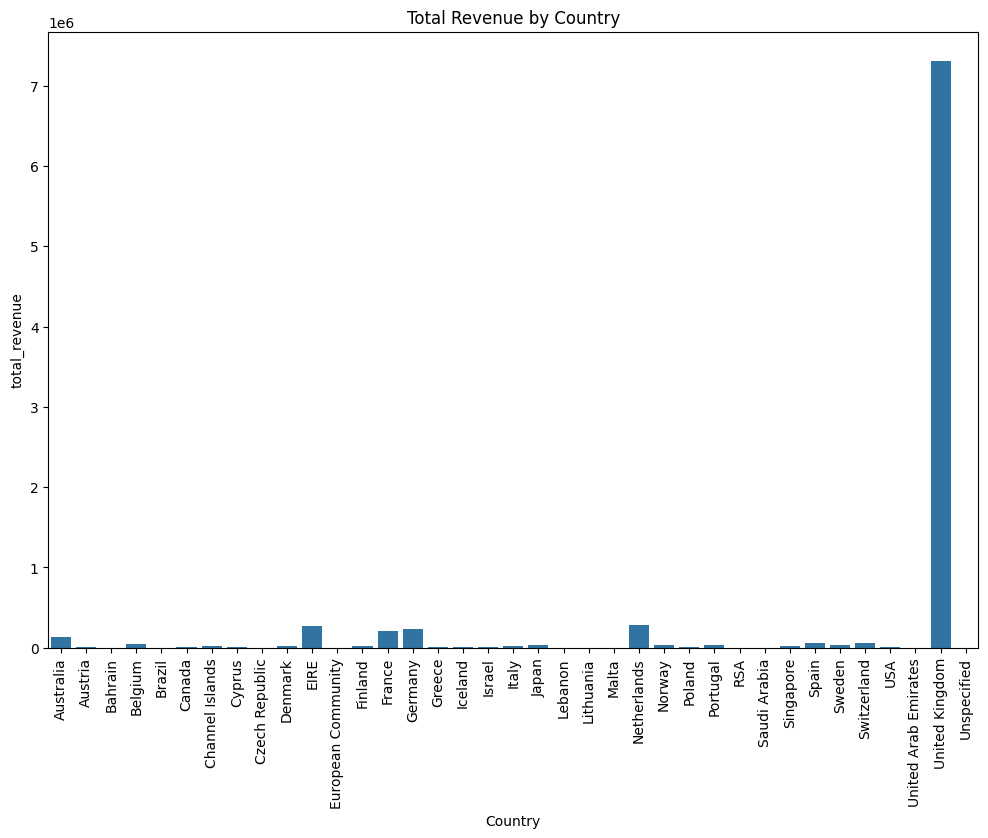

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Country', y='total_revenue', data=country_agg)
plt.title('Total Revenue by Country')
plt.xticks(rotation=90)
plt.show()

In [ ]:
df_uk = df[df['Country'] == 'United Kingdom']
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [ ]:
rfm = recency_df.merge(frequency_df, on='CustomerID').merge(monetary_df, on='CustomerID')
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,18,1,1757.55
4,12350,310,1,334.40


In [ ]:
rfm.to_csv('rfm_clustering_results.csv', index=False)

In [ ]:
# Calculate the total price per invoice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Calculate Average Order Value (AOV)
aov = df.groupby('CustomerID').agg({'TotalPrice': 'sum', 'InvoiceNo': 'nunique'}).reset_index()
aov['AOV'] = aov['TotalPrice'] / aov['InvoiceNo']
aov = aov[['CustomerID', 'AOV']]


In [ ]:
# Calculate Purchase Frequency (F)
total_orders = df['InvoiceNo'].nunique()
purchase_freq = df.groupby('CustomerID').agg({'InvoiceNo': 'nunique'}).reset_index()
purchase_freq['Frequency'] = purchase_freq['InvoiceNo'] / total_orders
purchase_freq = purchase_freq[['CustomerID', 'Frequency']]


In [ ]:
# Merge AOV and Purchase Frequency data
customer_value_df = aov.merge(purchase_freq, on='CustomerID')

# Calculate Customer Value (CV)
customer_value_df['CustomerValue'] = customer_value_df['AOV'] * customer_value_df['Frequency']


In [ ]:
# Assume a retention rate
retention_rate = 0.7

# Calculate churn rate
churn_rate = 1 - retention_rate

# Estimate customer lifetime (L)
customer_value_df['CustomerLifetime'] = 1 / churn_rate


In [ ]:
# Assume a gross margin (adjust based on your business)
gross_margin = 0.3

In [ ]:
# Calculate CLTV
customer_value_df['CLTV'] = customer_value_df['CustomerValue'] * customer_value_df['CustomerLifetime'] * gross_margin

# Display the final dataframe with CLTV
print(customer_value_df[['CustomerID', 'AOV', 'Frequency', 'CustomerValue', 'CustomerLifetime', 'CLTV']].head())

  CustomerID           AOV  Frequency  CustomerValue  CustomerLifetime  \
0      12346  77183.600000   0.000054       4.163984          3.333333   
1      12347    615.714286   0.000378       0.232521          3.333333   
2      12348    449.310000   0.000216       0.096959          3.333333   
3      12349   1757.550000   0.000054       0.094818          3.333333   
4      12350    334.400000   0.000054       0.018041          3.333333   

       CLTV  
0  4.163984  
1  0.232521  
2  0.096959  
3  0.094818  
4  0.018041  
